<a href="https://www.kaggle.com/code/charmainechiam/dealing-with-missing-values-in-data-preparation?scriptVersionId=138962939" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Hi!

This is a study project using the reference from https://www.kaggle.com/code/kaanboke/the-most-used-methods-to-deal-with-missing-values. This notebook has fantastic points and highlights essential concepts in data cleaning to make sure that data is well prept before moving into further analysis or model training. 

In this study, we will use XGBoost Algorithm, which is an ensemble algorithm of decision trees. It does not require normalization for inputs. 

## 1. Handling Missing Data
- Machine learning algorithms don't work with missing values.
- Missing values needs to be removed or replaced.
- Several factors can cause missing data: structural deficiencies in data (e.g clinical studies - patient dies, etc.), merging with other datasets, random events, failure of measurement, etc.


## 2. Understanding the Data
It is always important to understand the data before we start doing anything. Here, we are using the water quality data which measures 9 metrics to determine the potability as an indication whether the water is safe for consumption. 1 means Potable and 0 means Not potable.

1. pH value:
PH is an important parameter in evaluating the acid–base balance of water. It is also the indicator of acidic or alkaline condition of water status. WHO has recommended maximum permissible limit of pH from 6.5 to 8.5. The current investigation ranges were 6.52–6.83 which are in the range of WHO standards.

2. Hardness:
Hardness is mainly caused by calcium and magnesium salts. These salts are dissolved from geologic deposits through which water travels. The length of time water is in contact with hardness producing material helps determine how much hardness there is in raw water. Hardness was originally defined as the capacity of water to precipitate soap caused by Calcium and Magnesium.

3. Solids (Total dissolved solids - TDS):
Water has the ability to dissolve a wide range of inorganic and some organic minerals or salts such as potassium, calcium, sodium, bicarbonates, chlorides, magnesium, sulfates etc. These minerals produced un-wanted taste and diluted color in appearance of water. This is the important parameter for the use of water. The water with high TDS value indicates that water is highly mineralized. Desirable limit for TDS is 500 mg/l and maximum limit is 1000 mg/l which prescribed for drinking purpose.

4. Chloramines:
Chlorine and chloramine are the major disinfectants used in public water systems. Chloramines are most commonly formed when ammonia is added to chlorine to treat drinking water. Chlorine levels up to 4 milligrams per liter (mg/L or 4 parts per million (ppm)) are considered safe in drinking water.

5. Sulfate:
Sulfates are naturally occurring substances that are found in minerals, soil, and rocks. They are present in ambient air, groundwater, plants, and food. The principal commercial use of sulfate is in the chemical industry. Sulfate concentration in seawater is about 2,700 milligrams per liter (mg/L). It ranges from 3 to 30 mg/L in most freshwater supplies, although much higher concentrations (1000 mg/L) are found in some geographic locations.

6. Conductivity:
Pure water is not a good conductor of electric current rather’s a good insulator. Increase in ions concentration enhances the electrical conductivity of water. Generally, the amount of dissolved solids in water determines the electrical conductivity. Electrical conductivity (EC) actually measures the ionic process of a solution that enables it to transmit current. According to WHO standards, EC value should not exceeded 400 μS/cm.

7. Organic_carbon:
Total Organic Carbon (TOC) in source waters comes from decaying natural organic matter (NOM) as well as synthetic sources. TOC is a measure of the total amount of carbon in organic compounds in pure water. According to US EPA < 2 mg/L as TOC in treated / drinking water, and < 4 mg/Lit in source water which is use for treatment.

8. Trihalomethanes:
THMs are chemicals which may be found in water treated with chlorine. The concentration of THMs in drinking water varies according to the level of organic material in the water, the amount of chlorine required to treat the water, and the temperature of the water that is being treated. THM levels up to 80 ppm is considered safe in drinking water.

9. Turbidity:
The turbidity of water depends on the quantity of solid matter present in the suspended state. It is a measure of light emitting properties of water and the test is used to indicate the quality of waste discharge with respect to colloidal matter. The mean turbidity value obtained for Wondo Genet Campus (0.98 NTU) is lower than the WHO recommended value of 5.00 NTU.

Reference: https://www.kaggle.com/datasets/adityakadiwal/water-potability?datasetId=1292407&sortBy=voteCount

## 3. Importing Libraries

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import plotly 
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import missingno as msno

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('../input/water-potability/water_potability.csv')
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


At first glance, we can see there are already missing values, NaN. 

In [3]:
df.shape

(3276, 10)

This means we have 3276 instances, with 9 input (features/attributes) and 1 output variable (label)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


info is a great way to show how many missing values are in each features. Here we can see that ph, Sulfat, Trihalomethanes have NaN values.

In [5]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


The describe() method is a very good way to understand the overview of the satistics of a dataset. 

1.The mean and median should be close, if not the data may be skewed.
2. Based on the mean-median values of the 9 input variables, they seem to have very close to normal distribution with slight skewness.


**Target Variable** 

In [6]:
df['Potability'].value_counts(normalize=True) #NORMALIZE TO PERCENTAGE

0    0.60989
1    0.39011
Name: Potability, dtype: float64

- Almost %61 of the instances of our target variable is 'Potable'
- %39 of the instances of our target variable is 'Not Potable'


**Skewness**

In [7]:
df.drop('Potability', axis=1).skew()


ph                 0.025630
Hardness          -0.039342
Solids             0.621634
Chloramines       -0.012098
Sulfate           -0.035947
Conductivity       0.264490
Organic_carbon     0.025533
Trihalomethanes   -0.083031
Turbidity         -0.007817
dtype: float64

## 4. Univariate Analysis
Univariate analysis is basically the simplest form to analyze data. Uni means one and this means that the data has only one kind of variable. The major reason for univariate analysis is to use the data to describe. The analysis will take data, summarise it, and then find some pattern in the data.

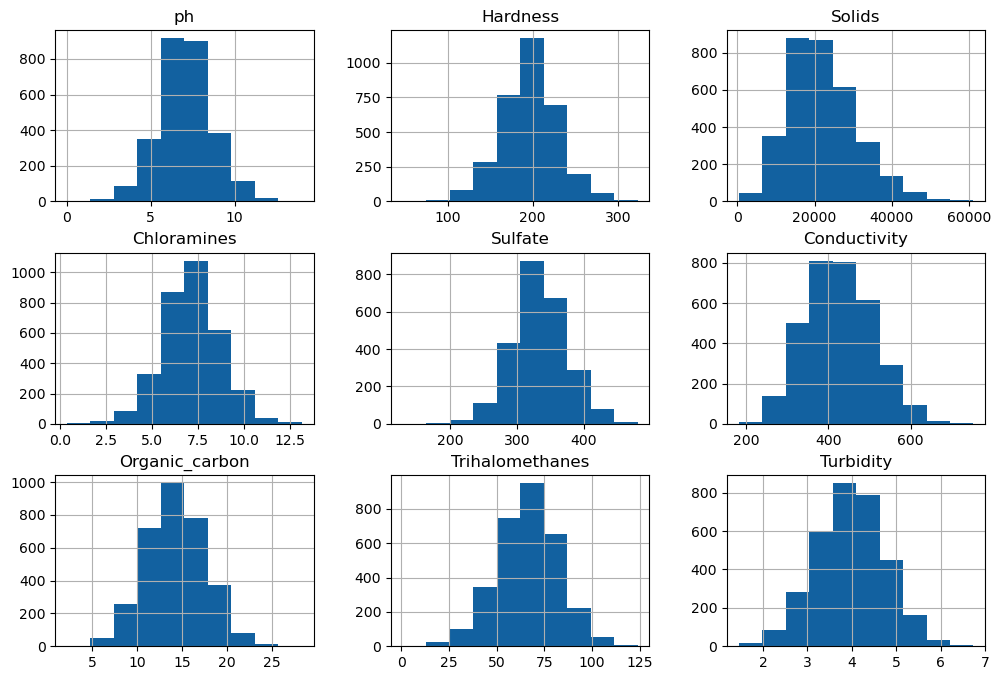

In [8]:
df.drop('Potability', axis = 1).hist(figsize=(12,8), color="#1261A0");

## 5. Bivariate Analysis
Bivariate analysis refers to the analysis of two variables to determine relationships between them. There are a few ways we can do this:

1. corr()
2. scatter plot matrix using correlations
3. heatmaps

In [9]:
df.corr()
#kinda similar to heatmap but without the nice colors ;D

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
ph,1.000000,0.082096,-0.089288,-0.034350,0.018203,0.018614,0.043503,0.003354,-0.039057,-0.003556
Hardness,0.082096,1.000000,-0.046899,-0.030054,-0.106923,-0.023915,0.003610,-0.013013,-0.014449,-0.013837
Solids,-0.089288,-0.046899,1.000000,-0.070148,-0.171804,0.013831,0.010242,-0.009143,0.019546,0.033743
Chloramines,-0.034350,-0.030054,-0.070148,1.000000,0.027244,-0.020486,-0.012653,0.017084,0.002363,0.023779
Sulfate,0.018203,-0.106923,-0.171804,0.027244,1.000000,-0.016121,0.030831,-0.030274,-0.011187,-0.023577
Conductivity,0.018614,-0.023915,0.013831,-0.020486,-0.016121,1.000000,0.020966,0.001285,0.005798,-0.008128
Organic_carbon,0.043503,0.003610,0.010242,-0.012653,0.030831,0.020966,1.000000,-0.013274,-0.027308,-0.030001
Trihalomethanes,0.003354,-0.013013,-0.009143,0.017084,-0.030274,0.001285,-0.013274,1.000000,-0.022145,0.007130
Turbidity,-0.039057,-0.014449,0.019546,0.002363,-0.011187,0.005798,-0.027308,-0.022145,1.000000,0.001581
Potability,-0.003556,-0.013837,0.033743,0.023779,-0.023577,-0.008128,-0.030001,0.007130,0.001581,1.000000


In [10]:
#use pandas label encoding
vals = df['Potability'].astype('category').cat.codes

fig = go.Figure(data=go.Splom(
                dimensions=[dict(label='ph',
                                 values=df['ph']),
                            dict(label='Hardness',
                                 values=df['Hardness']),
                            dict(label='Solids',
                                 values=df['Solids']),
                            dict(label='Chloramines',
                                 values=df['Chloramines']),
                           dict(label='Sulfate',
                                 values=df['Sulfate']),
                            dict(label='Conductivity',
                                 values=df['Conductivity']),
                            dict(label='Organic_carbon',
                                 values=df['Organic_carbon']),
                            dict(label='Trihalomethanes',
                                 values=df['Trihalomethanes']),
                           dict(label='Turbidity',
                                 values=df['Turbidity'])],
                showupperhalf=False, 
                text=df['Potability'],
                marker=dict(color=vals,
                            showscale=False, #the color
                            line_color='white', line_width=0.5)
                ))

fig.update_layout(
    title='Water Quality',
    width=1000,
    height=1000,
)

fig.show()

In [11]:
fig = go.Figure(go.Heatmap(z=df.corr(), x=df.corr().columns.tolist(),
                           y=df.corr().columns.tolist(), colorscale='Viridis'))

fig.show()

As observed in the correlation matric, scatterplots and heatmap, there is no strong relatioship between the variables.

## 6. Missing Values
- Visualisations and getting numeric summaries are the first step in understanding missing information in a dataset.
- Identifying how many and what type of missing values are is an important first step when deciding what to do next.

In [12]:
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

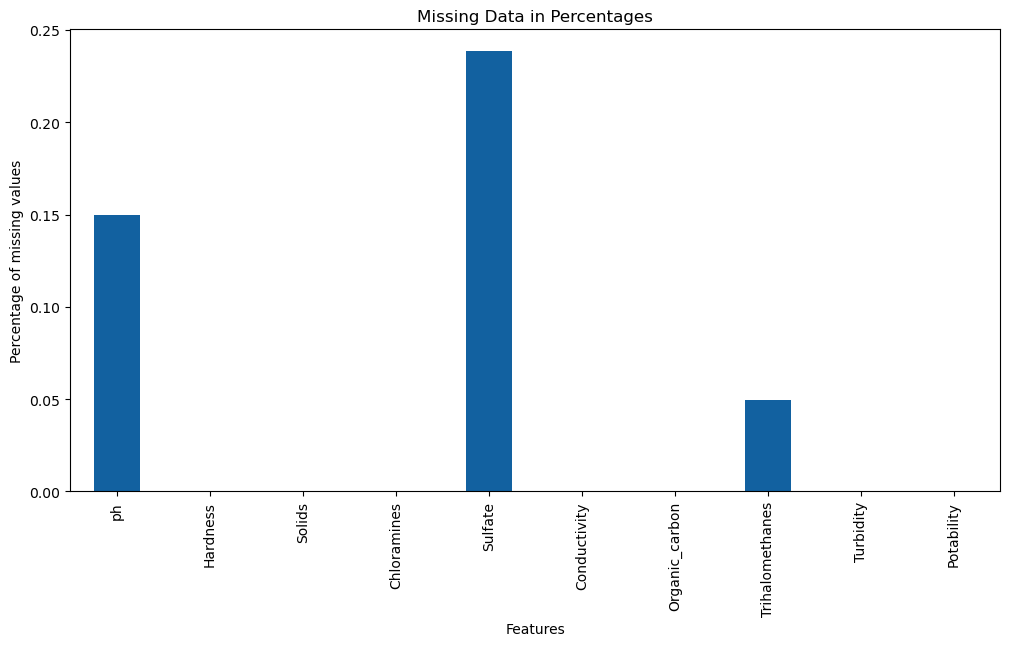

In [13]:
#you can use visualisation to see the % of missing values
df.isnull().mean().plot.bar(figsize=(12,6), color='#1261A0') 
plt.ylabel('Percentage of missing values') 
plt.xlabel('Features') 
plt.title('Missing Data in Percentages');

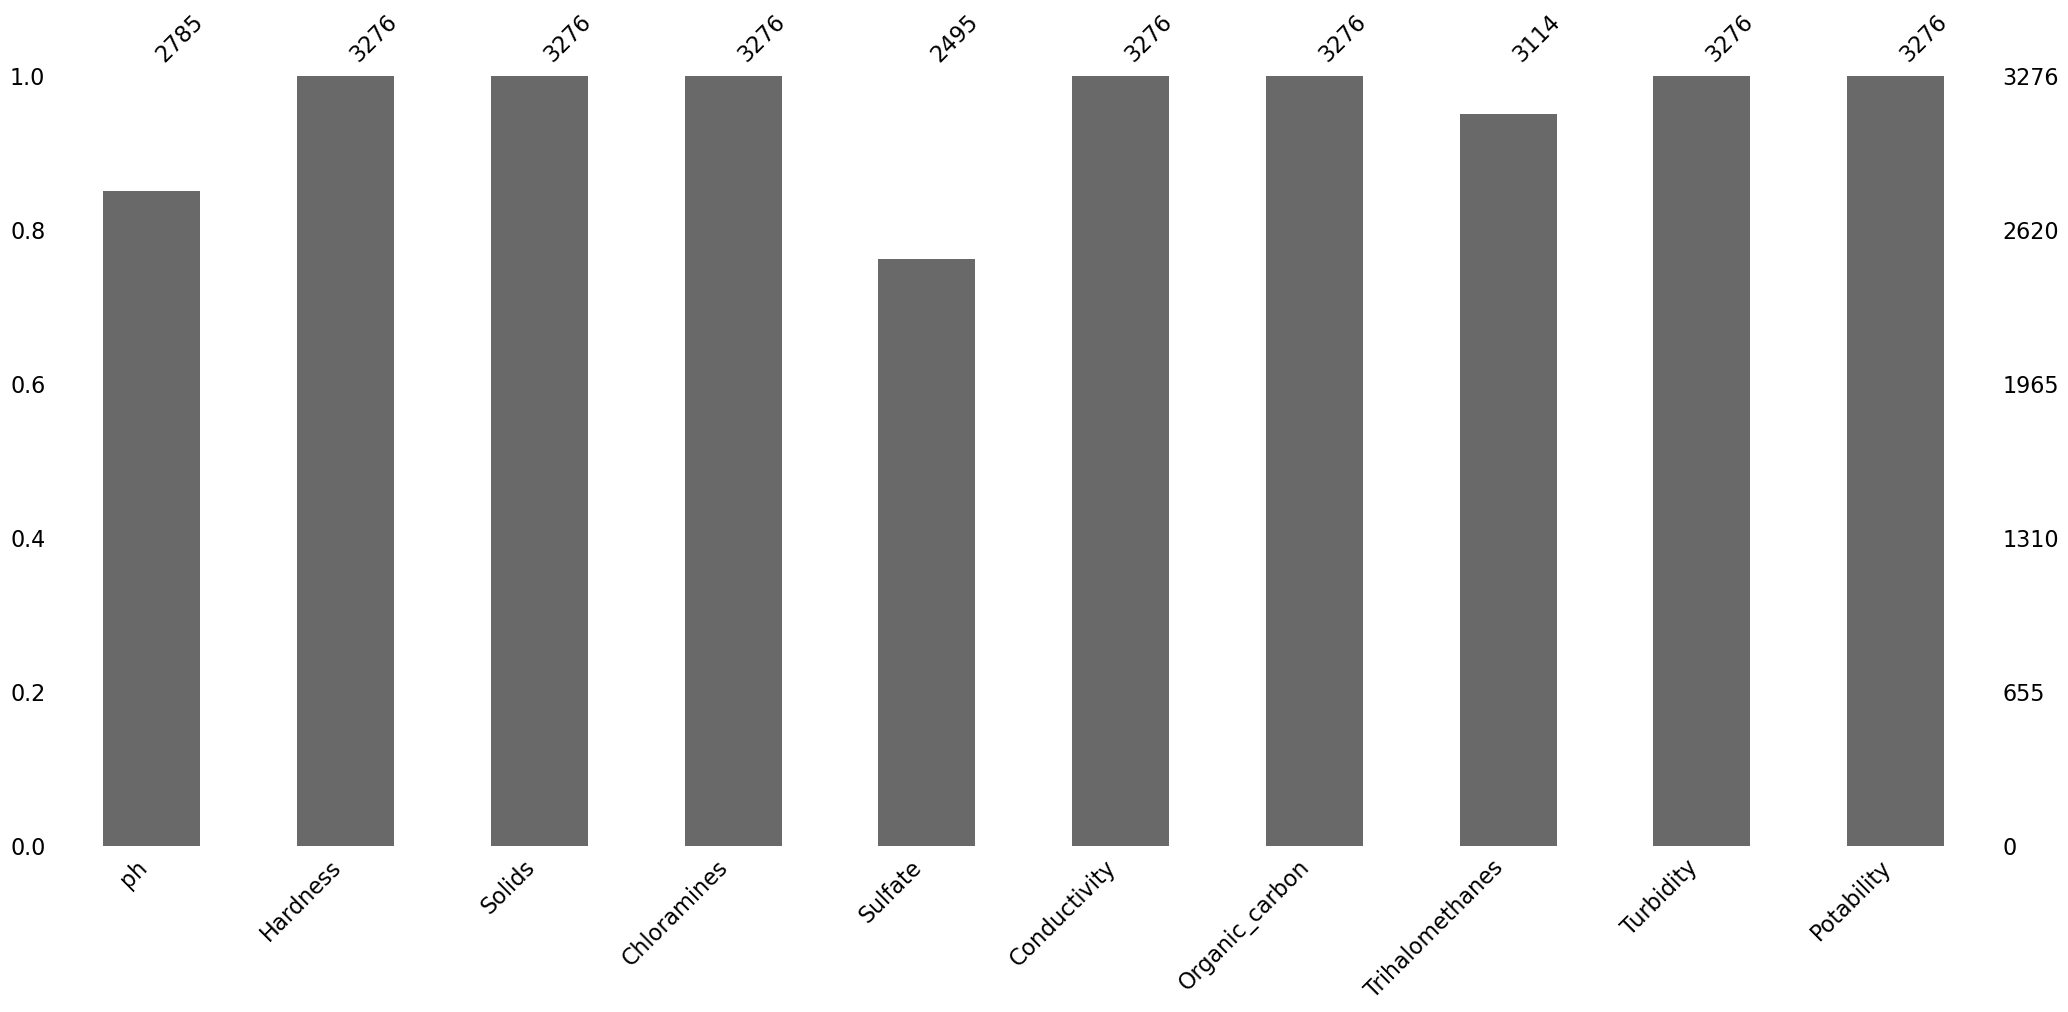

In [14]:
#or using missingno library
msno.bar(df);


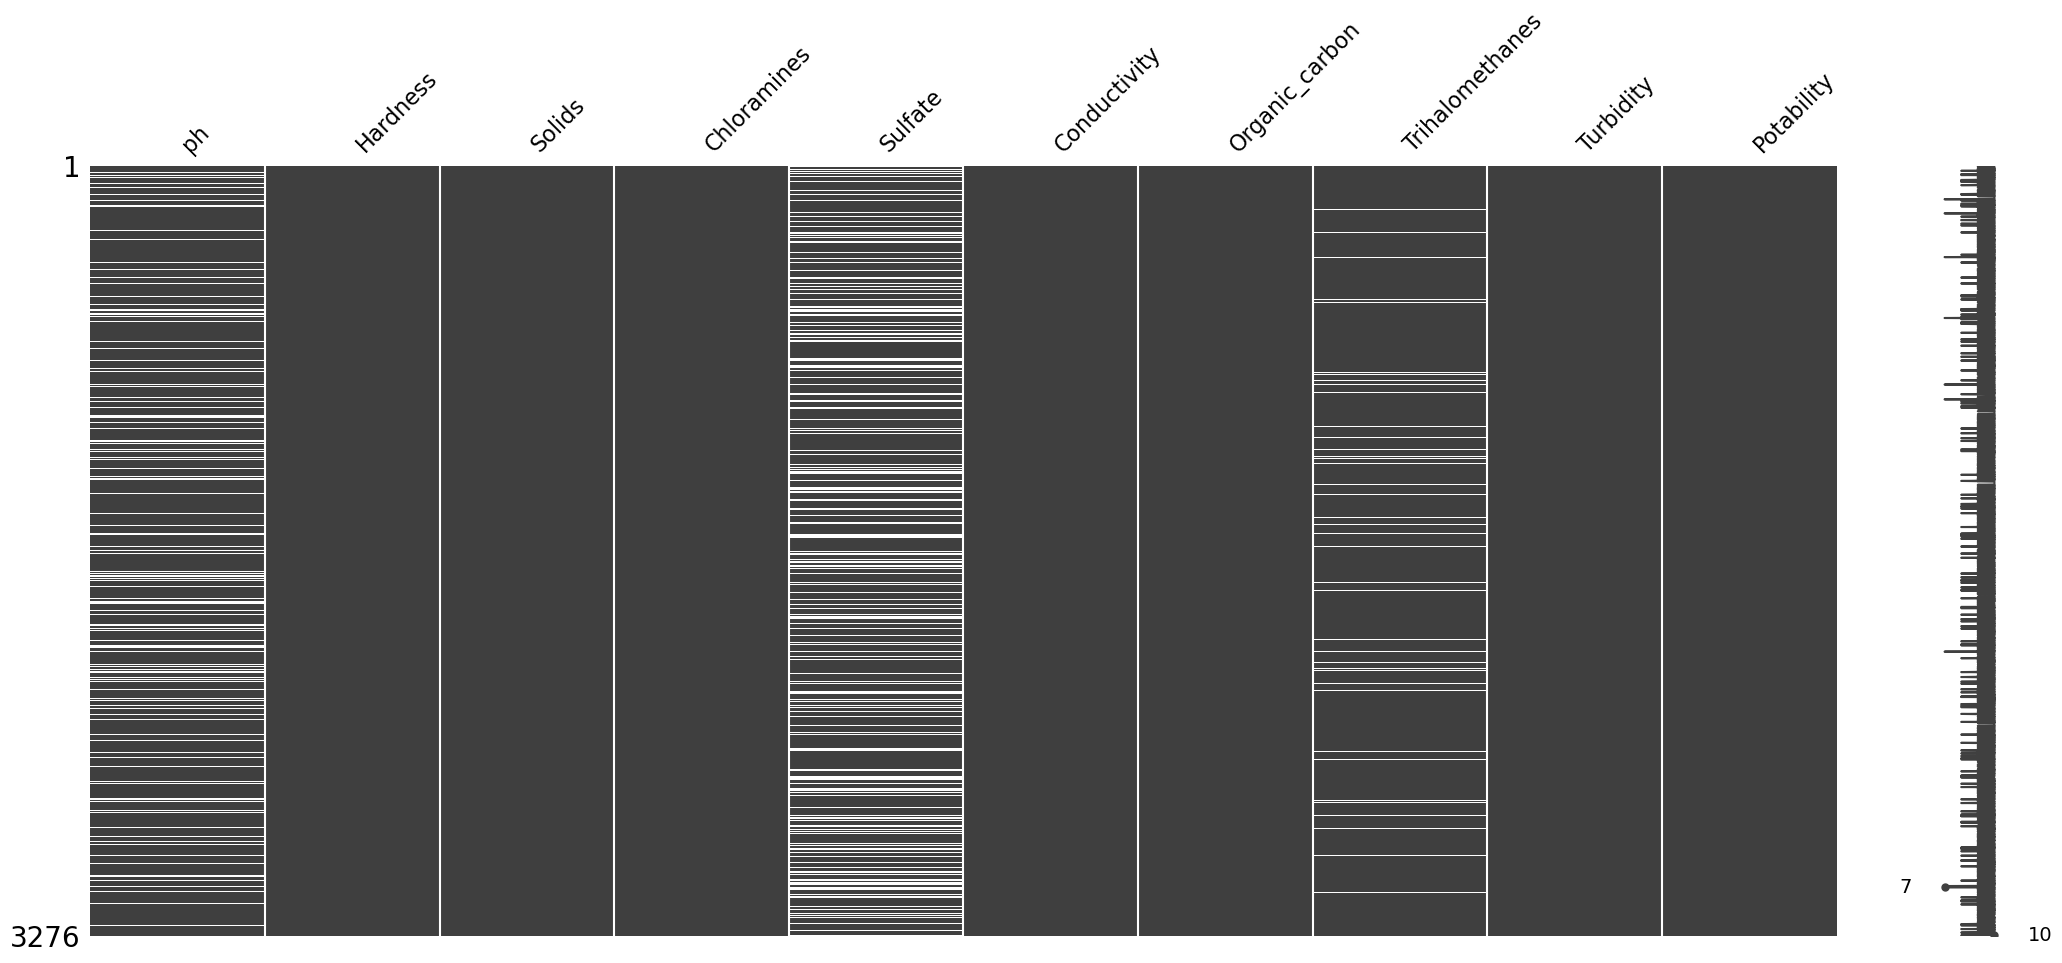

In [15]:
msno.matrix(df);
# or missingno matrix which gives location and pattern of missing data

Most algorithms don't work with missing values, but there are a few exceptions and **XGBoost Algorithm** is one of them.

We will use this algorithm WITH and WITHOUT missing values to see what the difference is. 

**Dealing with Missing Values**
 The most used methods for dealing with NaNs:
 1. Removing observations with missing data
 2. Performaing mean or median imputation
 3. Replacing missing values with arbituary numbers
 4. Dealing missing values in Categorical Variable
 5. Imputing values in ML pipeline
 6. Nearest neighbour imputation (k-nearest neighbour imputation)

### 6.1 Removing observations with missing data

- Advice not to use it until it is the last resort 
- Date is precious and removing data would potentially remove meaningful insights or patterns
- Missing data can be a sign of significant concept in data collection stage or give an indication about the data

In [16]:
print(f'Before dropping, we have {df.shape[0]} instances.')

df_dropped = df.dropna()
print(f'After dropping, we have {df_dropped.shape[0]} instances.')

dropped_percentage = ((df.shape[0]-df_dropped.shape[0])/float(df.shape[0]))*100

#To see how many instances we lost
print(f'Lost instances = {df.shape[0]-df_dropped.shape[0]} instances, which is {round(dropped_percentage)}%.')


Before dropping, we have 3276 instances.
After dropping, we have 2011 instances.
Lost instances = 1265 instances, which is 39%.


In [17]:
df_dropped.isnull().sum()
#to show we have no more NaNs

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [18]:
#remove target to make training set with only the variables
X = df_dropped.drop('Potability', axis=1)
#only keep truth label for testing set
y = df_dropped['Potability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f'Size of X_train: {X_train.shape[0]}')

#training the XGB model
model = XGBClassifier(eval_metric='logloss')
model.fit(X_train, y_train)
predictions_m1 = model.predict(X_test)

accuracy_m1 = accuracy_score(y_test, predictions_m1)
print(f'The accuracy score is {round(accuracy_m1*100,3)}')

Size of X_train: 1407
The accuracy score is 65.728


**Model without removing missing values**
Let's see if the XGB model will perform much worse if the missing values were not removed. 

In [19]:
X = df.drop('Potability', axis=1)
y = df['Potability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f'Size of X_train without removing NaNs: {X_train.shape[0]}')

model = XGBClassifier(eval_metric='logloss')
model.fit(X_train, y_train)
predictions_m2 = model.predict(X_test)

accuracy_m2 = accuracy_score(y_test, predictions_m2)
print(f'The accuracy score for dataset with missing values is {round(accuracy_m2*100, 3)}.')

Size of X_train without removing NaNs: 2293
The accuracy score for dataset with missing values is 65.819.


- XGB Model without missing values =  65.73% ↓
- XGB Model with missing values = 65.82% ↑

### 6.2 Mean and Median Imputation
- The aim is to impute values that are as close as possible to their original values.
- In literature, mostly 20% missing data is suggested as a threshold to impute data. But in real life, we have many other factors to consider before deciding it.

<u>**IMPORTANT POINTS**</u>
<br>**Mean, median imputation should be calculated by using ONLY TRAIN DATA, not the WHOLE DATA!!</br>
<br>Imputation should only occur before scaling and centering, otherwise, the resulting means and std will inherit the potential biases and issues incurred from data deletion</br>



In [20]:
df = pd.read_csv('../input/water-potability/water_potability.csv')

X = df.drop('Potability', axis=1)
y = df['Potability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

X_train.head(5)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
2985,NaN,188.445469,28791.614416,8.040356,382.009477,422.234861,10.575690,63.235365,3.228379
1073,7.203439,168.445358,22826.484697,6.283250,271.892045,437.370863,16.410654,64.505923,6.389161
3140,NaN,242.827588,29298.074262,5.853840,340.348645,463.115174,5.426650,NaN,3.522586
2643,6.056818,211.765886,4440.277357,9.507303,NaN,316.921776,17.766397,53.541191,3.358061
2174,9.581189,223.296216,28292.780318,5.665431,NaN,398.479317,11.350768,44.574120,3.929178


In [21]:
X_train.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
count,1939.000000,2293.000000,2293.000000,2293.000000,1731.000000,2293.000000,2293.000000,2180.000000,2293.000000
mean,7.096329,196.551035,22113.841276,7.114603,333.687852,426.699124,14.252296,66.450922,3.958445
std,1.590718,32.823436,8899.279189,1.575875,41.631895,81.657696,3.290887,16.288173,0.777717
min,0.000000,73.492234,728.750830,0.352000,129.000000,181.483754,4.371899,8.175876,1.492207
25%,6.096154,176.753500,15737.468938,6.105708,307.592458,367.854025,12.049131,55.746769,3.434538
50%,7.015333,197.331291,20988.429410,7.131704,332.349949,421.890083,14.171164,66.697224,3.941074
75%,8.074703,217.283262,27215.902742,8.107067,360.259558,481.853415,16.557177,77.578607,4.496627
max,14.000000,323.124000,61227.196008,13.043806,481.030642,753.342620,28.300000,124.000000,6.739000


In [22]:
X_train.skew()
#no significant skewness, solid shows slight right skew (positive value)

ph                 0.044774
Hardness          -0.029392
Solids             0.669942
Chloramines       -0.033637
Sulfate           -0.044098
Conductivity       0.282242
Organic_carbon     0.015405
Trihalomethanes   -0.097298
Turbidity         -0.014962
dtype: float64

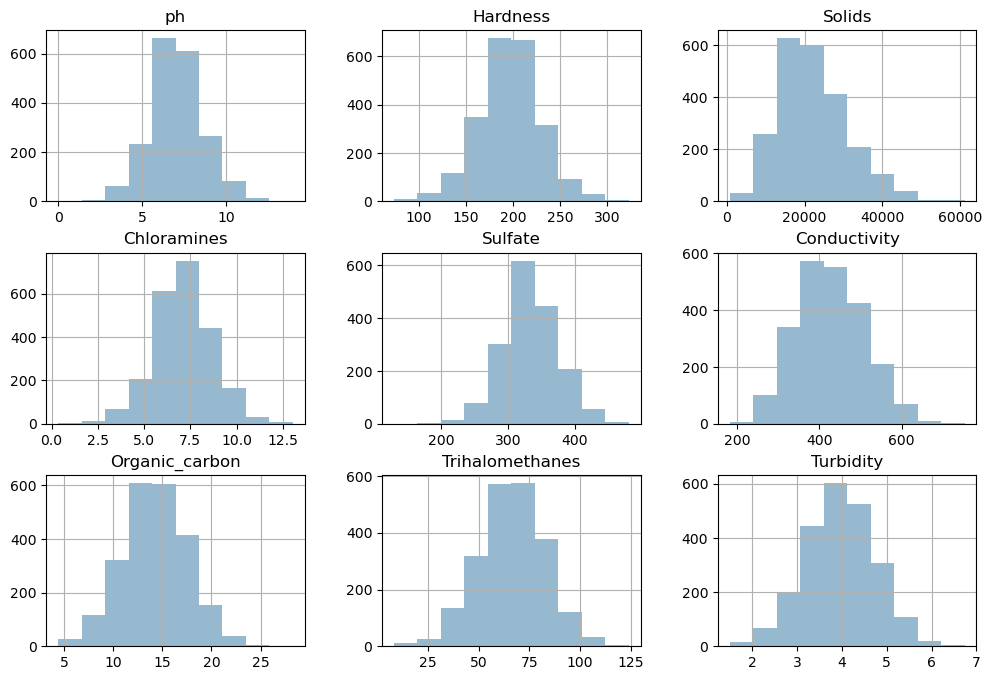

In [23]:
X_train.hist(figsize=(12,8), color='#96B9D0');

The results are very close to the original dataset. We will use scikit learn **SimpleImputer** to imput missing values. Eventhough our features have very low skewness, it would be better to use median instead of mean.

Mean imputation is often used when the missing values are numerical and the distribution of the variable is approximately normal. Median imputation is preferred when the distribution is skewed, as the median is less sensitive to outliers than the mean. Reference: https://vitalflux.com/pandas-impute-missing-values-mean-median-mode/#:~:text=Mean%20imputation%20is%20often%20used,to%20outliers%20than%20the%20mean.

In [24]:
imputer = SimpleImputer(strategy='median') 
#'mean' for mean and 'most_frequent' for mode

imputer.fit(X_train) #learns median from X_train data

X_train = imputer.transform(X_train) #replace missing values with medians
X_test = imputer.transform(X_test)

In [25]:
#this will return a numpy array which we need to convert to pandas dataframe
print(type(X_train))
type(X_test)

<class 'numpy.ndarray'>


numpy.ndarray

In [26]:
X_test=pd.DataFrame(X_test)
X_train= pd.DataFrame(X_train)
X_train.head()

,0,1,2,3,4,5,6,7,8
0,7.015333,188.445469,28791.614416,8.040356,382.009477,422.234861,10.575690,63.235365,3.228379
1,7.203439,168.445358,22826.484697,6.283250,271.892045,437.370863,16.410654,64.505923,6.389161
2,7.015333,242.827588,29298.074262,5.853840,340.348645,463.115174,5.426650,66.697224,3.522586
3,6.056818,211.765886,4440.277357,9.507303,332.349949,316.921776,17.766397,53.541191,3.358061
4,9.581189,223.296216,28292.780318,5.665431,332.349949,398.479317,11.350768,44.574120,3.929178


In [27]:
#Training 
model = XGBClassifier(eval_metric='logloss')
model.fit(X_train, y_train)
predictions_m3 = model.predict(X_test)
print(f'Size of X_train: {X_train.shape[0]}')
accuracy_m3 = accuracy_score(y_test, predictions_m3)
print(f'Accuracy score with median replacing NaNs is {round(accuracy_m3*100,3)}')

Size of X_train: 2293
Accuracy score with median replacing NaNs is 65.717


**So far our results are:**
- XGB Model without missing values =  65.73% ↓
- XGB Model with missing values = 65.82% ↑
- XGB Model with median imputation = 65.72% ↓

### 6.3 K-Nearest Neighbour (KNN) Imputation
- When training set is small or moderate in size, KNN can be a quick and effective method for imputing missing values.
- This method identifies a sample with one or more missing values, then it identifies the most similar samples inthe training data that are not missing values. The similarity between samples are defined by distance metric.
- Once the k nearest neighbour are found, their values are used to imput the missing data.

In [28]:
df = pd.read_csv('../input/water-potability/water_potability.csv')

X = df.drop('Potability', axis=1)
y = df['Potability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

imputer = KNNImputer()

model = XGBClassifier(eval_metric='logloss')

KNN_pipeline = Pipeline(steps=[('imputer', imputer),('model', model)])

KNN_pipeline.fit(X_train, y_train)

predictions_m4 = KNN_pipeline.predict(X_test)

accuracy_m4 = accuracy_score(y_test, predictions_m4)


kfold = KFold(n_splits=10, random_state=42, shuffle=True)

results = cross_val_score(model, X, y, cv=kfold)



print(f'Accuracy: {round(accuracy_m4*100,3)} Results Mean : %{round(results.mean()*100,3)} | Results Standard Deviation : {round(results.std()*100,3)}')

Accuracy: 64.903 Results Mean : %63.827 | Results Standard Deviation : 2.056


In [29]:
#making dataframes to plot
scores_df = pd.DataFrame(data=[accuracy_m1, accuracy_m2, accuracy_m3, accuracy_m4],
                         columns=['XGB Accuracy Scores'],
                         index=["Removing missing values", "Keeping missing values","Median Imputation", "KNN Imputation"])
scores_df

,XGB Accuracy Scores
Removing missing values,0.657285
Keeping missing values,0.658189
Median Imputation,0.657172
KNN Imputation,0.649034


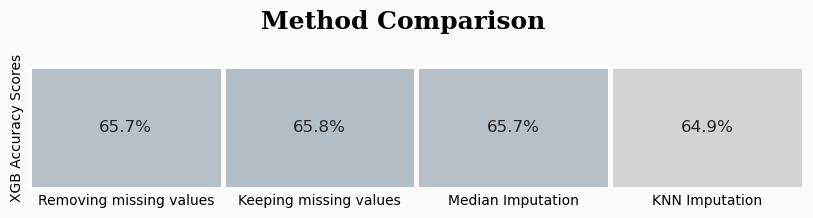

In [30]:
import matplotlib
colors = ["lightgray","lightgray","#0f4c81"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

background_color = "#fbfbfb"

fig = plt.figure(figsize=(10,4)) # create figure
gs = fig.add_gridspec(2,1)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])

sns.heatmap(scores_df.T, cmap=colormap,annot=True,fmt=".1%",vmin=0.6,vmax=0.7, linewidths=2.5,cbar=False,ax=ax0,annot_kws={"fontsize":12})
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 

ax0.text(1.2, -0.3, 'Method Comparison',fontsize=18,fontweight='bold',fontfamily='serif')
ax0.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

## 7. Conclusion
It is important how we handle missing values in machine learning. The type of methods we use should depend on how and why the missing values occurs. The best approach is to try to keep the data rather than removing them because data is valuable and often times, they give some indication of other potential factors that may have caused an issue during data collection. 